# Dask Array

In [ ]:
import numpy as np
import dask.array as da
import timeit
from dask.dot import dot_graph
import h5py
import time
from prettytable import PrettyTable

1. Создайте массив размерностью 1000 на 300000, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики полученного массива.

In [ ]:
arr = np.random.normal(size=(1000, 300000))
print('Математическое ожидание (среднее значение):', np.mean(arr))
print('Стандартное отклонение:', np.std(arr))
print('Минимальное значение:', np.min(arr))
print('Максимальное значение:', np.max (arr))
print('Медиана:', np.median(arr))
print('Дисперсия:', np.var(arr))

Математическое ожидание (среднее значение): -1.331223987657855e-05
Стандартное отклонение: 1.0000091126369084
Минимальное значение: -6.319795844244005
Максимальное значение: 5.977480420633476
Медиана: 3.7963203014705946e-05
Дисперсия: 1.0000182253568568


2. Посчитайте сумму квадратов элементов массива, созданного в задаче 1. Создайте массив `np.array` такого же размера и сравните скорость решения задачи с использование `da.array` и `np.array`

In [ ]:
print("Сумма квадратов элементов массива:", np.sum(arr**2))
arr = da.random.normal(size= (1000, 300000), chunks=(100, 100000))

sum_squares = da.sum(arr**2)
print("Сумма квадратов элементов массива (Dask):", sum_squares.compute())

arr = np.random.normal(size= (1000, 300000))
darr = da.from_array(arr, chunks=100)
def np_sum_squares():
    return np.sum(arr**2)
def da_sum_squares():
    return da.sum(darr**2).compute()
print("Время выполнения пр.sum():", timeit.timeit(np_sum_squares, number=1))
print("Время выполнения da.sum():", timeit.timeit(da_sum_squares, number=1))

Сумма квадратов элементов массива: 300005467.660223
Сумма квадратов элементов массива (Dask): 300053867.75259876
Время выполнения пр.sum(): 0.9620368820000067
Время выполнения da.sum(): 13.752338731999998


3. Визуализируйте граф вычислений для задачи 12.

In [ ]:
! pip install graphviz

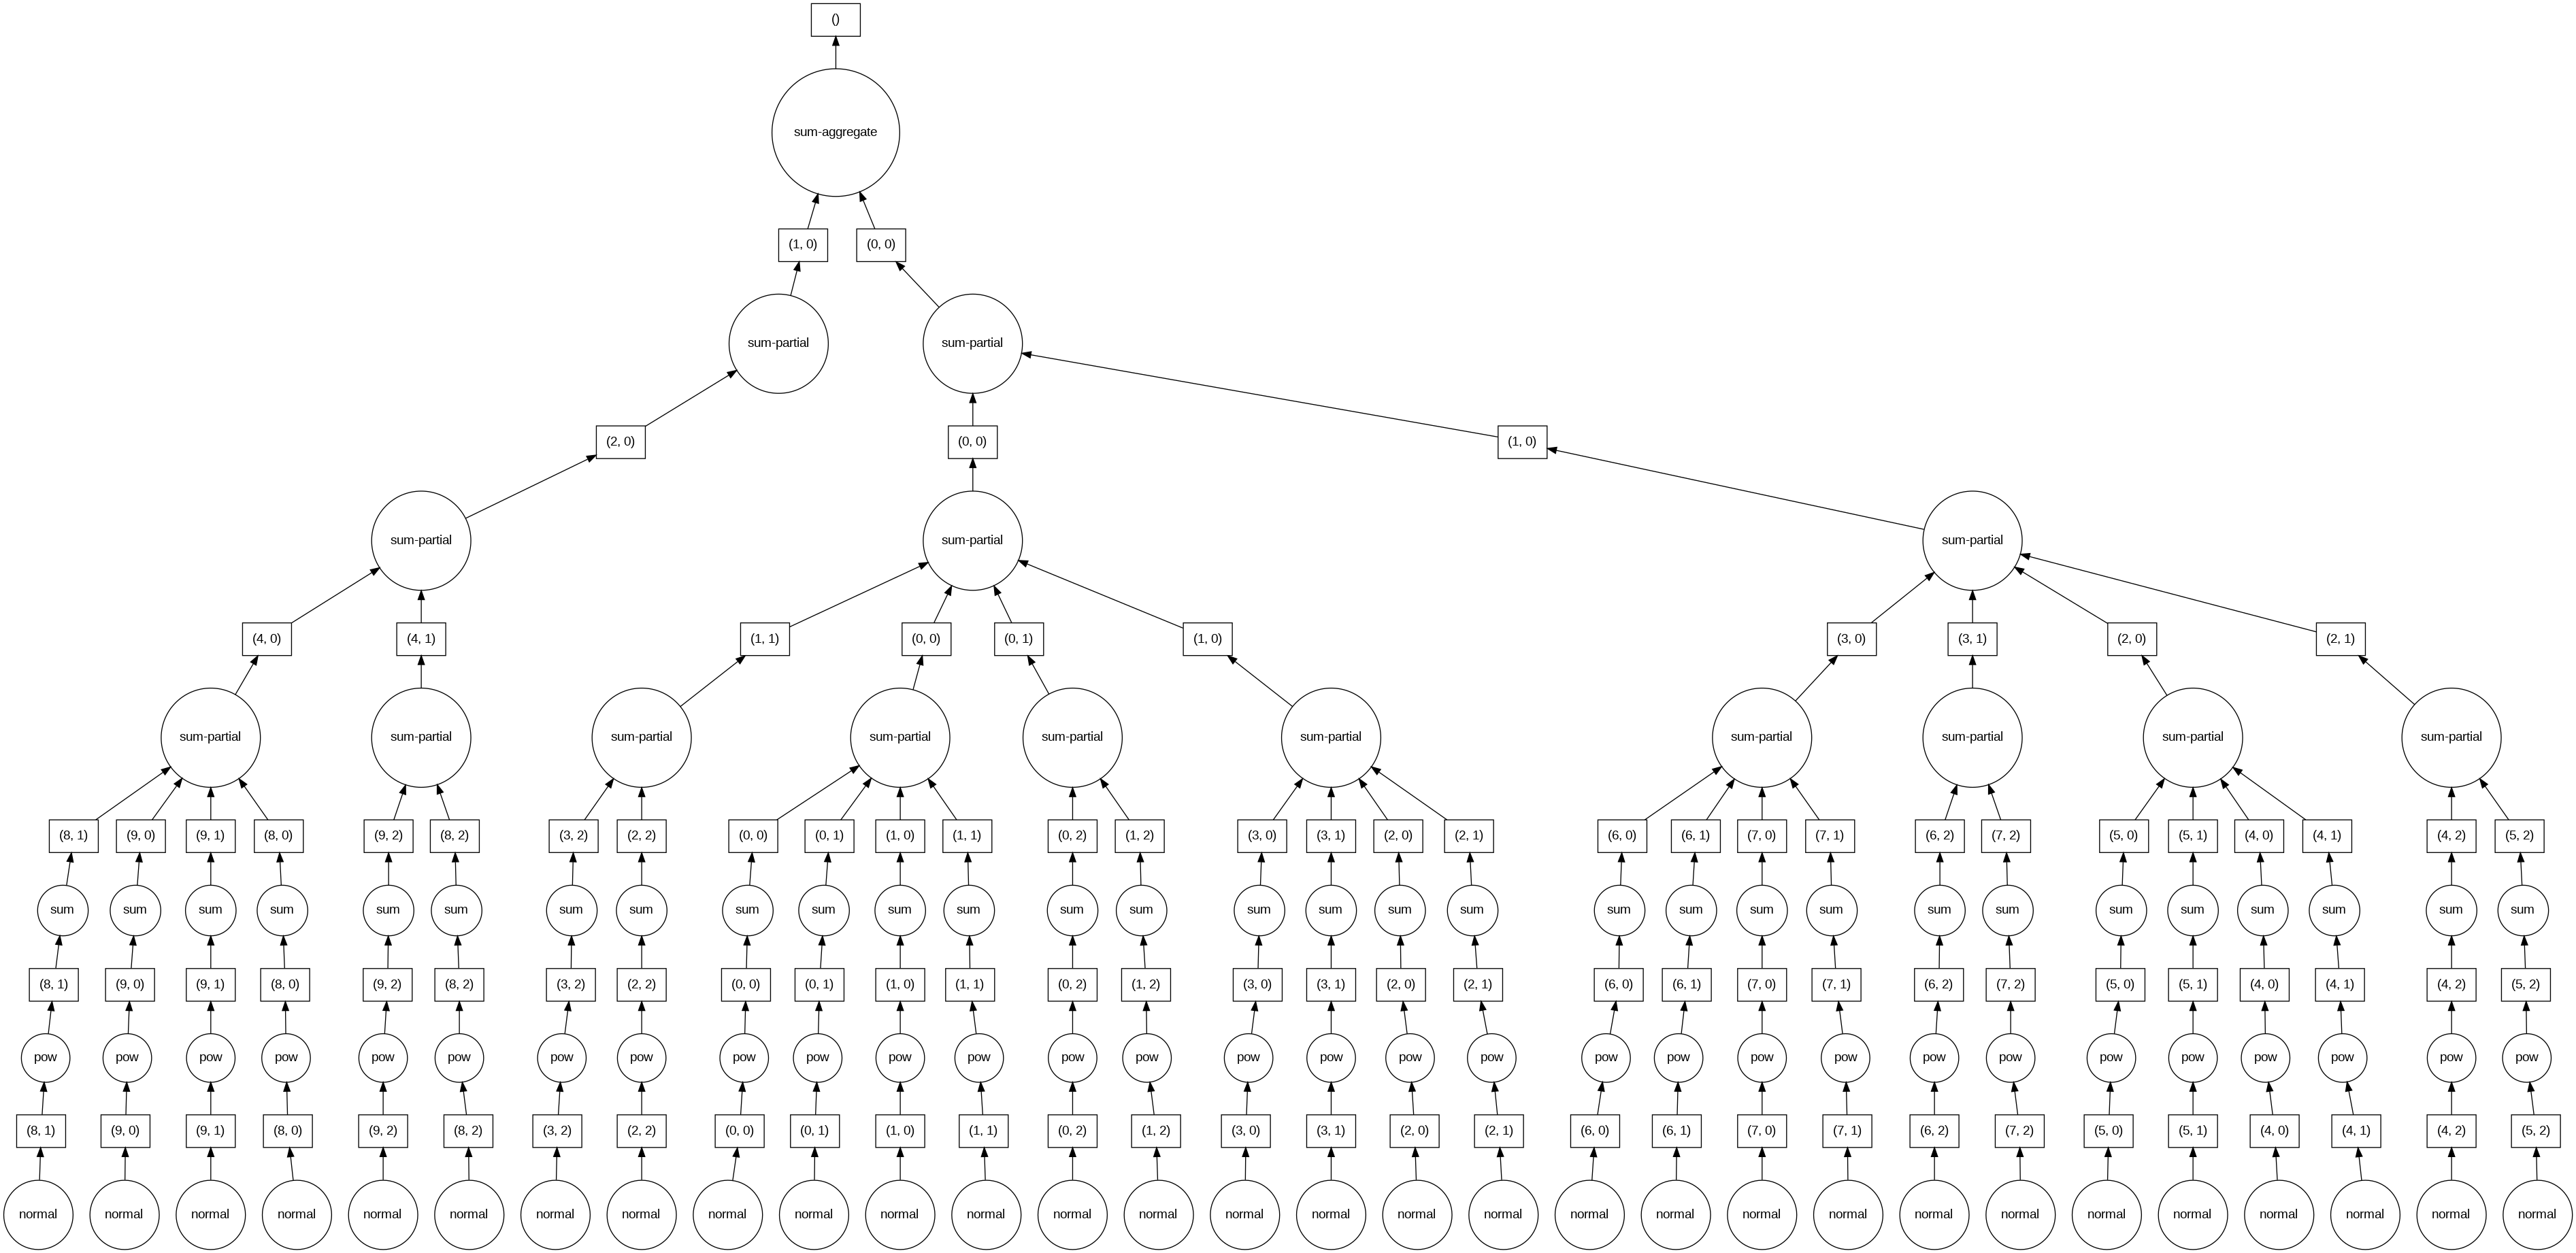

In [ ]:
x = da.random.normal(size=(1000, 300000), chunks=(100, 100000))
y = (x ** 2).sum()
y.visualize()

# Продолжение:

1. Считайте датасет `recipe` из файла `minutes_n_ingredients_full.hdf5` в виде `dask.array`. Укажите аргумент `chunks=(100_000, 3)` при создании массива. Выведите на экран основную информацию о массиве.

In [ ]:
data_f  = h5py.File('/content/minutes_n_ingredients_full.hdf5', 'r')
data_set = data_f['/recipe']
dask_array = da.from_array(data_set, chunks=(100_000, 3))

print(f"Форма массива: {dask_array.shape}")
print(f"Размер чанков: {dask_array.chunks}")
print(f"Тип данных: {dask_array.dtype}")
print(f"Количество элементов: {dask_array.size}")

Форма массива: (2231637, 3)
Размер чанков: ((100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 31637), (3,))
Тип данных: int64
Количество элементов: 6694911


2. Вычислите среднее значение по каждому столбцу, кроме первого.

In [ ]:
mean_values = dask_array[:, 1:].mean(axis=0)

print(mean_values.compute())

[1004.20805176    5.4198008 ]


3. Исследуйте, как влияет значение аргумента `chunks` при создании `dask.array` на скорость выполнения операции поиска среднего.

In [ ]:
chunk_sizes = [(10_000, 3), (50_000, 3), (100_000, 3), (200_000, 3), (500_000, 3)]
times = []
for chunk_temp in chunk_sizes:
    strat_time = time.time()
    dask_array = da.from_array(data_set, chunks=chunk_temp)
    mean_temp = dask_array.mean(axis=1).compute()
    times.append(time.time() - strat_time)

print([f'{chunk_sizes[i]} time = {times[i]}' for i in range(len(chunk_sizes))])

['(10000, 3) time = 0.2420799732208252', '(50000, 3) time = 0.10147333145141602', '(100000, 3) time = 0.09722638130187988', '(200000, 3) time = 0.09380793571472168', '(500000, 3) time = 0.0903475284576416']


4. Выберите рецепты, время выполнения которых меньше медианного значения

In [ ]:
dask_array = da.from_array(data_set, chunks=(500_000, 3))
mediane_temp = da.median(dask_array[:, 1], axis=0).compute()
print(f"Медианное время выполнения рецепта: {mediane_temp}")

Медианное время выполнения рецепта: 32.0


In [ ]:
filtered_recipes = dask_array[dask_array[:, 1] < mediane_temp].compute()
print("Первые 5 рецептов с временем выполнения меньше медианного:")
print(filtered_recipes[:5])

Первые 5 рецептов с временем выполнения меньше медианного:
[[1089012      23       5]
 [1428572       0       5]
 [1400250      24       1]
 [1798295      29       5]
 [ 818815      21       5]]


5. Посчитайте количество каждого из возможных значений кол-ва ингредиентов

In [ ]:
# return_counts=True возвращает количество вхождений каждого уникального значения
# zip берёт два итерируемых объекта и объединяет их в пары (кортежи)
unique_ingredients, counts = da.unique(dask_array[:, 2], return_counts=True)
for ingredient, count in zip(unique_ingredients.compute(), counts.compute()):
    print(f"{ingredient}: {count}")

1: 222071
2: 224158
3: 229388
4: 234948
5: 240720
6: 244360
7: 247181
8: 246747
9: 246816
10: 22430
11: 19094
12: 15165
13: 11640
14: 8284
15: 6014
16: 4145
17: 2793
18: 1913
19: 1279
20: 852
21: 529
22: 346
23: 244
24: 178
25: 107
26: 68
27: 55
28: 33
29: 22
30: 20
31: 13
32: 5
33: 4
34: 3
35: 4
36: 1
37: 2
38: 1
39: 1
40: 2
43: 1


6. Найдите максимальную продолжительность рецепта. Ограничьте максимальную продолжительность рецептов сверху значением, равному 75% квантилю.

In [ ]:
max_minutes = da.max(dask_array[1], axis=0).compute()
max_minutes

1089012

In [ ]:
quantile_75 = da.percentile(dask_array[:, 1], 75).compute()[0]
print(quantile_75)

49.0


In [ ]:
recipes_filtered_75 = dask_array[dask_array[:, 1] <= quantile_75]
recipes_filtered_75.compute()[:5]

array([[ 683970,      33,       9],
       [1089012,      23,       5],
       [1428572,       0,       5],
       [1400250,      24,       1],
       [ 387709,      47,      10]])

7. Создайте массив `dask.array` из 2 чисел, содержащих ваши предпочтения относительно времени выполнения рецепта и кол-ва ингредиентов. Найдите наиболее похожий (в смысле $L_1$) рецепт из имеющихся в датасете.

In [ ]:
temp = da.array([20, 5])
recipes_info = dask_array[:, 1:]

l1_distances = da.abs(recipes_info - temp).sum(axis=1)
l1_distances.compute()

array([17,  3, 20, ..., 43, 24, 47])

In [ ]:
min_distance_index = da.argmin(l1_distances).compute()
closest_recipe = recipes_info[min_distance_index].compute()
print(f'Индекс рецепта с минимальным расстоянием: {min_distance_index}, {closest_recipe}')

Индекс рецепта с минимальным расстоянием: 617, [20  5]


8. Работая с исходным файлом в формате `hdf5`, реализуйте алгоритм подсчета среднего значения в блочной форме и вычислите с его помощью среднее значение второго столбца в массиве.

Блочный алгоритм вычислений состоит из двух частей:
1. Загрузка фрагмента за фрагментом данных по `blocksize` элементов и проведение вычислений на этим фрагментом
2. Агрегация результатов вычислений на различных фрагментах для получения результата на уровне всего набора данных

Важно: при работе с `h5py` в память загружаются не все элементы, а только те, которые запрашиваются в данный момент

In [ ]:
filename = '/content/minutes_n_ingredients_full.hdf5'
blocksize = 5000

with h5py.File(filename, 'r') as file:
    dataset = file['recipe']

    total_sum = 0
    total_count = 0

    for start in range(0, dataset.shape[0], blocksize):
        end = min(start + blocksize, dataset.shape[0])
        block = dataset[start:end]

        total_sum += np.sum(block[:, 1])
        total_count += block.shape[0]

    mean_value = total_sum / total_count
    print(mean_value)

1004.2080517575215
